In [5]:
import os

import sys
os.chdir("/Users/zyxu/Documents/py/kris")
import numpy as np
import pandas as pd
import h5py
import hdf5plugin

import func.prepro as pp
import gc

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))

In [6]:
DATA_DIR = "open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [7]:
# took ~3mins
train_multi_inputs = pp.readH5pyFile(FP_MULTIOME_TRAIN_INPUTS)
train_multi_targets = pp.readH5pyFile(FP_MULTIOME_TRAIN_TARGETS)
# test_multi_inputs = readH5pyFile(FP_MULTIOME_TEST_INPUTS)

In [8]:
train_cite_inputs = pp.readH5pyFile(FP_CITE_TRAIN_INPUTS)
train_cite_targets = pp.readH5pyFile(FP_CITE_TRAIN_TARGETS)
# test_cite_inputs = pp.readH5pyFile(FP_CITE_TEST_INPUTS)

In [ ]:
y_protein = train_cite_targets['block0_values']
y_RNA = train_multi_targets['block0_values']

In [7]:
for key, val in train_cite_inputs.items():
    print(f"{key} shape is {val.shape}")

axis0 shape is (22050,)
axis1 shape is (70988,)
block0_items shape is (22050,)
block0_values shape is (70988, 22050)


In [8]:
print(train_multi_targets['axis0'].astype(str)[:10])
print(train_cite_targets['axis0'].astype(str)[:10])

['ENSG00000121410' 'ENSG00000268895' 'ENSG00000175899' 'ENSG00000245105'
 'ENSG00000166535' 'ENSG00000256661' 'ENSG00000184389' 'ENSG00000128274'
 'ENSG00000094914' 'ENSG00000081760']
['CD86' 'CD274' 'CD270' 'CD155' 'CD112' 'CD47' 'CD48' 'CD40' 'CD154'
 'CD52']


In [13]:
train_RNA = train_cite_inputs['block0_values']
y_protein = train_cite_targets['block0_values']
y_protein.shape

(70988, 140)

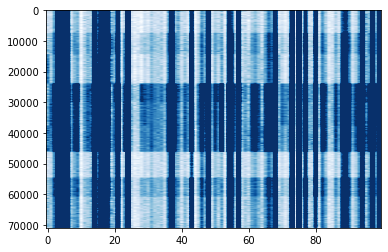

In [19]:
plt.imshow(y_protein[:,:100], cmap='Blues', aspect='auto', vmin=0, vmax=1)

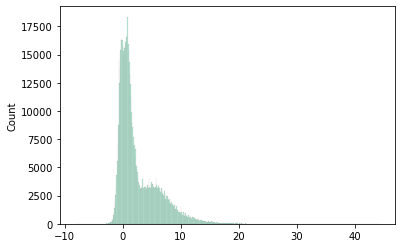

In [11]:
sns.histplot(data=y_protein[:,:10].reshape(-1))

In [16]:
y_RNA = train_multi_targets['block0_values']
y_RNA.shape

(105942, 23418)

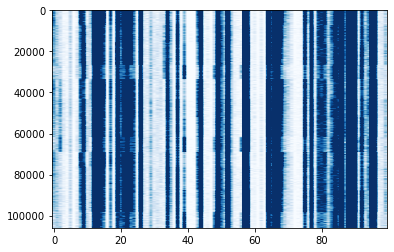

In [13]:
plt.imshow(y_RNA[:,:100], cmap='Blues', aspect='auto', vmin=0, vmax=1)

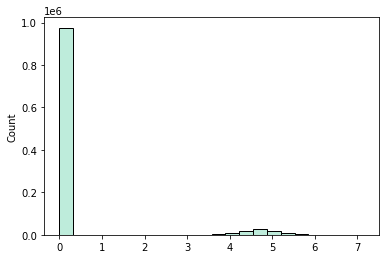

In [14]:
sns.histplot(data=y_RNA[:,:10].reshape(-1))

### train_test_split

In [14]:
split = int(y_protein.shape[0]*0.8)
y_protein_train, y_protein_test = y_protein[:split], y_protein[split:]

In [35]:
split = int(y_RNA.shape[0]*0.8)
y_RNA_train, y_RNA_test = y_RNA[:split], y_RNA[split:]

### group mean

In [36]:
y_RNA_train.shape

(84753, 23418)

In [30]:
protein = train_cite_targets['axis0'].astype(str)
RNA = train_multi_targets['axis0'].astype(str)

In [32]:
Y_mean_protein_train = y_protein_train.sum(0)/len(protein)

In [33]:
dict_target_protein = dict(map(lambda k: (k[1], Y_mean_protein_train[k[0]]), enumerate(protein)))

In [50]:
Y_mean_RNA_train = np.array([y_RNA_train[i:i+1000].sum(0) for i in range(0,y_RNA_train.shape[0],1000)]).sum(0)/y_RNA_train.shape[0]
Y_mean_RNA_train

array([0.52995737, 0.31796038, 0.35867017, ..., 1.16304014, 1.14629377,
       2.04471339])

In [51]:
dict_target_RNA = dict(map(lambda k: (k[1], Y_mean_RNA_train[k[0]]), enumerate(RNA)))

In [73]:
np.corrcoef(y_protein_test.reshape(-1), np.tile(Y_mean_protein_train, y_protein_test.shape[0]))

array([[1.        , 0.73756146],
       [0.73756146, 1.        ]])

In [74]:
np.corrcoef(y_RNA_test.reshape(-1), np.tile(Y_mean_RNA_train, y_RNA_test.shape[0]))

: 

: 

### kmeans

In [17]:
# kmeans
from sklearn.cluster import KMeans

In [18]:
km = KMeans(
    init="random",
    n_clusters= 10,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [19]:
km.fit(y_protein_train)

KMeans(init='random', n_clusters=10, random_state=42)

In [20]:
km.labels_[:10]

array([1, 1, 6, 5, 6, 6, 3, 1, 3, 1], dtype=int32)

In [28]:
pre_idx = km.predict(y_protein_test)
pre_protein = np.array([km.cluster_centers_[i] for i in pre_idx])

In [32]:
np.corrcoef(y_protein_test.reshape(-1), pre_protein.reshape(-1))

array([[1.        , 0.85147043],
       [0.85147043, 1.        ]])

In [33]:
from sklearn.cluster import MiniBatchKMeans
km_multi = MiniBatchKMeans(
    init="random",
    n_clusters= 10,
    n_init=10,
    max_iter=300,
    random_state=42,
    batch_size=1024
    )

In [37]:
for i in range(y_RNA_train.shape[0],1000):
    km_multi.partial_fit(y_RNA_train[i:i+1000])

In [40]:
km_multi.fit(y_RNA_train)

MiniBatchKMeans(init='random', max_iter=300, n_clusters=10, n_init=10,
                random_state=42)

In [44]:
km_multi.cluster_centers_.shape

(10, 23418)

In [42]:
pre_idx = km_multi.predict(y_RNA_test)


In [45]:
pre_RNA = np.array([km_multi.cluster_centers_[i] for i in pre_idx])

In [49]:
np.corrcoef(y_RNA_test.reshape(-1), pre_RNA.reshape(-1))

: 

: 